# Bayesian Belief Network #

In [28]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, BicScore 
from pgmpy.inference import VariableElimination
import re
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

df = pd.read_csv("encoded_df.csv")
df = df.drop(columns = ["id", "relDate"])
df = df[df.columns.drop(list(df.filter(regex="^country_")))]

df.head()

,date,minute,rating,relCountry_Argentina,relCountry_Australia,relCountry_Brazil,relCountry_Canada,relCountry_China,relCountry_Czechia,relCountry_Denmark,...,language_Spanish,language_Swedish,language_Tagalog,language_Tamil,language_Telugu,language_Thai,language_Turkish,language_Ukrainian,language_Urdu,language_Vietnamese
0,2023.0,114.0,3.86,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1999.0,139.0,4.27,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023.0,181.0,4.23,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019.0,122.0,3.85,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018.0,117.0,4.42,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Manually define the structure of the BBN
model1 = BayesianNetwork([("date", "minute"), ("rating", "minute")])

# Fit the BBN model
model1.fit(df, estimator = MaximumLikelihoodEstimator)
print(model1.edges())


[('date', 'minute'), ('rating', 'minute')]


While it potentially allows for us to get pretty granular in our resulting network, manually creating a model in this way is time consuming because of how we encoded our features such as genre and studio, where each individual genre or studio gets its own column. I'd like to try to automate this process if I can. I also worry that a model such as the one manually defined above could be too small or too skewed. 

## Hill Climb Search ##

Hill climb search is a greedy search algorithm that can be used to learn the optimal structure of BBNs. I'll try to use this method now.

In [30]:
# # Alternative model structure found using a scoring method
# # Sets up hill climb algorithm for searching over the possible network structures in our data
# hill_climb = HillClimbSearch(df) 
# # Runs the hill climb algo using the BIC scoring method to estimate the best BBN structure based on our dataset
# hc_model = hill_climb.estimate(scoring_method = BicScore(df))


The current encoded_df is too large/not encoded in such a way that this method is currently conducive. After allowing this cell to run for about 3 hours, it was still at 0% completion. I need smaller dataframes for the hill climb search to work. 

In [31]:
# Creating smaller dfs by batch-dropping columns. Resulting dfs are built around answering specific questions.

# Dataframe for genre questions:
genre_df = df[df.columns.drop(list(df.filter(regex="^(relCountry_|type_|studio_|language_)")))]

# Dataframe for release country questions:
relCountry_df = df[df.columns.drop(list(df.filter(regex="^(genre_|type_|studio_|language_)")))]

# Dataframe for film language questions:
language_df = df[df.columns.drop(list(df.filter(regex="^(relCountry_|type_|studio_|genre_)")))]

# Dataframe for studio questions:
studio_df = df[df.columns.drop(list(df.filter(regex="^(relCountry_|type_|genre_|language_)")))]

# Dataframe for release type questions:
releaseType_df = df[df.columns.drop(list(df.filter(regex="^(relCountry_|genre_|studio_|language_)")))]

studio_df.head()

,date,minute,rating,studio_20th Century Fox,studio_ARD,studio_ARTE,studio_ARTE France Cinéma,studio_American Mutoscope & Biograph,studio_BBC,studio_BFI,...,studio_WDR,studio_Walt Disney Pictures,studio_Walt Disney Productions,studio_Walter Lantz Productions,studio_Warner Bros. Cartoons,studio_Warner Bros. Pictures,studio_ZDF,studio_Československá televize Praha,studio_Československá televízia Bratislava,studio_Česká televize
0,2023.0,114.0,3.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1999.0,139.0,4.27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023.0,181.0,4.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019.0,122.0,3.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2018.0,117.0,4.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Testing hill climb on smaller genre df
hill_climb_genre = HillClimbSearch(genre_df)
hc_model_genre = hill_climb_genre.estimate(scoring_method = BicScore(genre_df))
print(hc_model_genre.edges())

  0%|          | 70/1000000 [00:02<10:31:45, 26.38it/s]

[('minute', 'genre_Animation'), ('genre_Action', 'genre_Comedy'), ('genre_Action', 'genre_Romance'), ('genre_Action', 'genre_Drama'), ('genre_Action', 'genre_Science Fiction'), ('genre_Action', 'genre_Documentary'), ('genre_Action', 'genre_Music'), ('genre_Action', 'genre_Mystery'), ('genre_Adventure', 'genre_Action'), ('genre_Adventure', 'genre_Science Fiction'), ('genre_Adventure', 'genre_Fantasy'), ('genre_Adventure', 'genre_Comedy'), ('genre_Animation', 'genre_Drama'), ('genre_Animation', 'genre_Family'), ('genre_Animation', 'genre_Romance'), ('genre_Animation', 'genre_Crime'), ('genre_Animation', 'genre_Thriller'), ('genre_Animation', 'genre_Documentary'), ('genre_Animation', 'genre_Horror'), ('genre_Animation', 'genre_TV Movie'), ('genre_Animation', 'genre_Western'), ('genre_Comedy', 'genre_History'), ('genre_Comedy', 'genre_Western'), ('genre_Comedy', 'genre_War'), ('genre_Comedy', 'genre_TV Movie'), ('genre_Crime', 'genre_Thriller'), ('genre_Crime', 'genre_Mystery'), ('genre_Cr

In [33]:
# Testing hill climb on release country df
hill_climb_relCountry = HillClimbSearch(relCountry_df)
hc_model_relCountry = hill_climb_relCountry.estimate(scoring_method = BicScore(relCountry_df))
print(hc_model_relCountry.edges())

  0%|          | 117/1000000 [00:10<23:45:53, 11.69it/s]

[('relCountry_Argentina', 'relCountry_Mexico'), ('relCountry_Argentina', 'relCountry_Japan'), ('relCountry_Argentina', 'relCountry_Philippines'), ('relCountry_Argentina', 'relCountry_Poland'), ('relCountry_Australia', 'relCountry_Netherlands'), ('relCountry_Australia', 'relCountry_Spain'), ('relCountry_Australia', 'relCountry_Portugal'), ('relCountry_Australia', 'relCountry_Germany'), ('relCountry_Australia', 'relCountry_Czechia'), ('relCountry_Australia', 'relCountry_USA'), ('relCountry_Australia', 'relCountry_Brazil'), ('relCountry_Australia', 'relCountry_Mexico'), ('relCountry_Australia', 'relCountry_Canada'), ('relCountry_Australia', 'relCountry_Italy'), ('relCountry_Australia', 'relCountry_Denmark'), ('relCountry_Brazil', 'relCountry_Spain'), ('relCountry_Brazil', 'relCountry_France'), ('relCountry_Brazil', 'relCountry_India'), ('relCountry_Brazil', 'relCountry_Greece'), ('relCountry_Canada', 'relCountry_Switzerland'), ('relCountry_Canada', 'relCountry_Russian Federation'), ('relC

In [34]:
# Testing hill climb on language df
hill_climb_language = HillClimbSearch(language_df)
hc_model_language = hill_climb_language.estimate(scoring_method = BicScore(language_df))
print(hc_model_language.edges())

  0%|          | 70/1000000 [00:09<37:48:07,  7.35it/s]

[('language_Arabic', 'language_Urdu'), ('language_Bengali, Bangla', 'language_Hindi'), ('language_Bengali, Bangla', 'language_Malay'), ('language_Catalan', 'language_Spanish'), ('language_Chinese', 'language_Cantonese'), ('language_Croatian', 'language_Serbian'), ('language_Czech', 'language_Slovak'), ('language_English', 'date'), ('language_English', 'language_Czech'), ('language_English', 'language_Chinese'), ('language_English', 'language_Danish'), ('language_English', 'language_Tagalog'), ('language_French', 'language_English'), ('language_French', 'language_Arabic'), ('language_French', 'language_Czech'), ('language_French', 'language_Chinese'), ('language_French', 'language_Tagalog'), ('language_French', 'language_Romanian'), ('language_French', 'language_Hebrew\xa0(modern)'), ('language_German', 'language_French'), ('language_German', 'language_Japanese'), ('language_German', 'language_English'), ('language_German', 'language_Polish'), ('language_German', 'language_Italian'), ('

In [35]:
# Testing hill climb on studio df
hill_climb_studio = HillClimbSearch(studio_df)
hc_model_studio = hill_climb_studio.estimate(scoring_method = BicScore(studio_df))
print(hc_model_studio.edges())

  0%|          | 138/1000000 [00:25<50:19:06,  5.52it/s]

[('date', 'studio_RKO Radio Pictures'), ('studio_20th Century Fox', 'studio_Warner Bros. Pictures'), ('studio_20th Century Fox', 'studio_Metro-Goldwyn-Mayer'), ('studio_20th Century Fox', 'studio_Columbia Pictures'), ('studio_20th Century Fox', 'studio_Universal Pictures'), ('studio_20th Century Fox', 'studio_Paramount'), ('studio_20th Century Fox', 'studio_United Artists'), ('studio_20th Century Fox', 'studio_BBC'), ('studio_ARTE', 'studio_BR'), ('studio_ARTE', 'studio_NDR'), ('studio_ARTE', 'studio_RTS'), ('studio_ARTE', 'studio_WDR'), ('studio_BFI', 'studio_Film4 Productions'), ('studio_BR', 'studio_ORF'), ('studio_CNC', 'studio_ARTE France Cinéma'), ('studio_CNC', 'studio_France Télévisions'), ('studio_Canal+', 'studio_CNC'), ('studio_Canal+', 'studio_France Télévisions'), ('studio_Canal+', 'studio_France 2 Cinéma'), ('studio_Canal+', 'studio_France 3 Cinéma'), ('studio_Canal+', 'studio_StudioCanal'), ('studio_Columbia Pictures', 'studio_Warner Bros. Pictures'), ('studio_Columbia P

In [36]:
# Testing hill climb on smaller genre df
hill_climb_releaseType = HillClimbSearch(releaseType_df)
hc_model_releaseType = hill_climb_releaseType.estimate(scoring_method = BicScore(releaseType_df))
print(hc_model_releaseType.edges())

  0%|          | 9/1000000 [00:00<4:31:51, 61.31it/s]

[('date', 'type_Premiere'), ('type_Digital', 'date'), ('type_Digital', 'type_Theatrical'), ('type_Digital', 'type_Theatrical limited'), ('type_Premiere', 'type_Theatrical limited'), ('type_Premiere', 'type_Theatrical'), ('type_TV', 'type_Theatrical'), ('type_TV', 'type_Digital'), ('type_Theatrical limited', 'type_Theatrical')]


These smaller dataframes allow the hill climb search algorithm to complete, but it is not accurately finding the optimal structure for any of them. We don't need edges between all the unique studios or genres, we need edges between runtime and each unique studio or genre. Our encoding scheme might work better for some of the other models, but it seems to be a hindrance for an effective Bayesian Belief Network model. It looks like I need to manually build the structure of the BBN after all. 

## Regex Patterns ##

I still need to find a faster way to define the structure of the network other than manually entering all of the edges I want it to have since we have hundreds of features. I'm going to try to use regex patterns to group columns that are part of the same underlying feature.

In [37]:
# Define regex patterns for different groups
genre_pattern = re.compile(r"^genre_")
relCountry_pattern = re.compile(r"^relCountry_")
language_pattern = re.compile(r"^language_")
studio_pattern = re.compile(r"^studio_")
releaseType_pattern = re.compile(r"^type_")

# Identify columns that match the patterns
genre_columns = [col for col in df.columns if genre_pattern.match(col)]
relCountry_columns = [col for col in df.columns if relCountry_pattern.match(col)]
language_columns = [col for col in df.columns if language_pattern.match(col)]
studio_columns = [col for col in df.columns if studio_pattern.match(col)]
releaseType_columns = [col for col in df.columns if releaseType_pattern.match(col)]

print("Genre Columns:", genre_columns)

Genre Columns: ['genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western']


In [38]:
# # Genre model
# # Define the structure of the BBN
# model_genre = BayesianNetwork([("date", "minute"), ("rating", "minute")])
# # Manually add edges from grouped columns to primary feature of runtime
# for col in genre_columns:
#     model_genre.add_edge(col, "minute")

# # Fit the BBN model
# model_genre.fit(df, estimator = MaximumLikelihoodEstimator)
# print(model_genre.edges())


This method is not achieving success either. I initially tried to add all of my grouped columns into one model. This would not run because it was too large. Next, I tried to build similar models as I did with the hill climb search method, where each model was focused on a different batch of columns, (as seen above in my attempt of a model that focuses on genre). However, this too failed to run because it was still too large, giving me a MemoryError. 

So hill climb failed to find an optimal network structure that was relevant to the analysis we want to complete. Manually defining the BBN edges by using a grouping of columns relating to a shared feature tries to produce a network that is still too large for my machine to work with. I'm left to have to build many tiny BBNs that are really narrowed down on very specific features. This feels like a drawback in terms of being time consuming - if I wanted to analyze or predict the average runtime of movies produced by each studio, I need to make 73 separate BBNs, one for each unique studio value in our dataset. This is prohibitively expensive to my time. Additionally, I have concerns about limiting or skewing the data too much to produce useful results by doing it this way. Ideally, I would have one BBN that encapsulates all portions of interest from the dataset. 

## Limited BBN ##

That said, I need to produce some kind of results here. I can easily make a BBN that includes the rating, runtime, and release date, since those columns are in a format that works well with this type of model. I will include at least two columns from each of the other feature groupings - genre, studio, release type, release country, and language - so that I can at least complete some predictions to analyze from this type of model. 

In [39]:
# # Manually define the structure of the BBN
# model2 = BayesianNetwork([
#     ("date", "minute"), 
#     ("rating", "minute"), 
#     ("type_Theatrical", "minute"), 
#     ("type_Digital", "minute"), 
#     ("genre_Comedy", "minute"), 
#     ("genre_Drama", "minute"), 
#     ("studio_Walt Disney Pictures", "minute"), 
#     ("studio_Warner Bros. Pictures", "minute"), 
#     ("relCountry_USA", "minute"), 
#     ("relCountry_South Korea", "minute"), 
#     ("language_English", "minute"), 
#     ("language_Korean", "minute")
# ])

# # Fit the BBN model
# model2.fit(df, estimator = MaximumLikelihoodEstimator)
# print(model2.edges())


Unbelievably, after running for less than three minutes, this is still failing by producing too large of a BBN:

MemoryError: Unable to allocate 8.75 GiB for an array with shape (251, 37441798) and data type bool

Looks like I need to make yet smaller BBNs. I'll make use of model1 up above which contains just release date, runtime, and rating. Then I'll make a couple more that are just runtime and two features from a grouping.

In [40]:
# Manually define the structure of the BBNs
model3 = BayesianNetwork([("type_Theatrical", "minute"), ("type_Digital", "minute")])
model4 = BayesianNetwork([("genre_Comedy", "minute"), ("genre_Drama", "minute")])
model5 = BayesianNetwork([("studio_Walt Disney Pictures", "minute"), ("studio_Warner Bros. Pictures", "minute")])
model6 = BayesianNetwork([("relCountry_USA", "minute"), ("relCountry_South Korea", "minute")])
model7 = BayesianNetwork([("language_English", "minute"), ("language_Korean", "minute")])

# Fit the BBN models
model3.fit(df, estimator = MaximumLikelihoodEstimator)
print(model3.edges())

model4.fit(df, estimator = MaximumLikelihoodEstimator)
print(model4.edges())

model5.fit(df, estimator = MaximumLikelihoodEstimator)
print(model5.edges())

model6.fit(df, estimator = MaximumLikelihoodEstimator)
print(model6.edges())

model7.fit(df, estimator = MaximumLikelihoodEstimator)
print(model7.edges())

[('type_Theatrical', 'minute'), ('type_Digital', 'minute')]
[('genre_Comedy', 'minute'), ('genre_Drama', 'minute')]
[('studio_Walt Disney Pictures', 'minute'), ('studio_Warner Bros. Pictures', 'minute')]
[('relCountry_USA', 'minute'), ('relCountry_South Korea', 'minute')]
[('language_English', 'minute'), ('language_Korean', 'minute')]


## Inference and Prediction ##

### Predicting runtime based on rating and release date ###

One of the first things I want to look at is how much ratings correlate with runtime. My preliminary guess is that higher ratings are going to generally correspond to higher runtimes (greater than 2 and a half hours) and that lower-rated movies are more likely to be in the hour and a half range of length. 

In [41]:
# Perform inference on the chosen BBN model
inference1 = VariableElimination(model1)

# Query the network for probability of given variables
rating_query = inference1.query(variables = ["minute"], evidence = {"rating": 4.23})
print(rating_query)

# Extract the values and state names
values1 = rating_query.values
states1 = rating_query.state_names["minute"]

# Find the index of the maximum probability
max_index1 = values1.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state1 = states1[max_index1]

# Get the maximum probability
max_prob1 = values1[max_index1]
print(f"The runtime with the highest probability given a rating of 4.23 is {max_state1} minutes with a probability of {max_prob1:.2f}")

+---------------+---------------+
| minute        |   phi(minute) |
+===============+===============+
| minute(1.0)   |        0.0036 |
+---------------+---------------+
| minute(2.0)   |        0.0036 |
+---------------+---------------+
| minute(3.0)   |        0.0036 |
+---------------+---------------+
| minute(4.0)   |        0.0036 |
+---------------+---------------+
| minute(5.0)   |        0.0036 |
+---------------+---------------+
| minute(6.0)   |        0.0036 |
+---------------+---------------+
| minute(7.0)   |        0.0036 |
+---------------+---------------+
| minute(8.0)   |        0.0036 |
+---------------+---------------+
| minute(9.0)   |        0.0036 |
+---------------+---------------+
| minute(10.0)  |        0.0036 |
+---------------+---------------+
| minute(11.0)  |        0.0036 |
+---------------+---------------+
| minute(12.0)  |        0.0036 |
+---------------+---------------+
| minute(13.0)  |        0.0036 |
+---------------+---------------+
| minute(14.0)

In [42]:
# Query the network for probability of given variables
rating_query2 = inference1.query(variables = ["minute"], evidence = {"rating": 2.06})

# Extract the values and state names
values2 = rating_query2.values
states2 = rating_query2.state_names["minute"]

# Find the index of the maximum probability
max_index2 = values2.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state2 = states2[max_index2]

# Get the maximum probability
max_prob2 = values2[max_index2]
print(f"The runtime with the highest probability given a rating of 2.06 is {max_state2} minutes with a probability of {max_prob2:.2f}")

The runtime with the highest probability given a rating of 2.06 is 114.0 minutes with a probability of 0.03


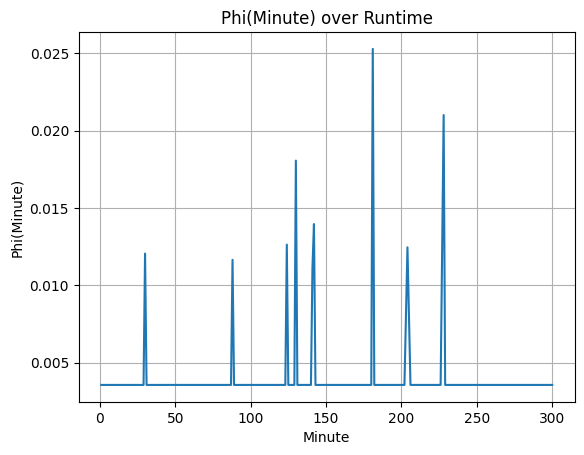

In [43]:
# Convert the DiscreteFactor to a dataframe
df_rating = pd.DataFrame(list(zip(rating_query.state_names["minute"], rating_query.values)), columns = ["minute", "phi(minute)"])

# Filter out outliers
filtered_df = df_rating[df_rating["minute"] <= 300]

# Plot the runtime probabilities for this rating
plt.plot(filtered_df["minute"], filtered_df["phi(minute)"])
plt.xlabel("Minute")
plt.ylabel("Phi(Minute)")
plt.title("Phi(Minute) over Runtime")
plt.grid(True)

The results of these queries only partially support my hypothesis - a movie rated 4.23 out of 5 is most likely to have a three hour runtime, while one rated 2.06 is most likely to be just shy of two hours long. Plotting the probabilities of runtimes most likely to achieve a 4.23 out of 5 rating shows that while 181 minutes is the best time to target to achieve that rating, a film between 125 and 145 minutes in length could also be a good length to target to achieve a well-rated film. 

I might next like to know whether runtimes are trending longer or shorter over a recent 20-year period. Let's see what the most likely runtimes are in 1999 and 2019. 

In [44]:
# Query the network for probability of given variables
date_query = inference1.query(variables = ["minute"], evidence = {"date": 1999.0})
print(date_query)

# Extract the values and state names
values3 = date_query.values
states3 = date_query.state_names["minute"]

# Find the index of the maximum probability
max_index3 = values3.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state3 = states3[max_index3]

# Get the maximum probability
max_prob3 = values3[max_index3]
print(f"The runtime with the highest probability given a release date of 1999 is {max_state3} minutes with a probability of {max_prob3:.2f}")

+---------------+---------------+
| minute        |   phi(minute) |
+===============+===============+
| minute(1.0)   |        0.0012 |
+---------------+---------------+
| minute(2.0)   |        0.0012 |
+---------------+---------------+
| minute(3.0)   |        0.0012 |
+---------------+---------------+
| minute(4.0)   |        0.0012 |
+---------------+---------------+
| minute(5.0)   |        0.0012 |
+---------------+---------------+
| minute(6.0)   |        0.0048 |
+---------------+---------------+
| minute(7.0)   |        0.0080 |
+---------------+---------------+
| minute(8.0)   |        0.0012 |
+---------------+---------------+
| minute(9.0)   |        0.0012 |
+---------------+---------------+
| minute(10.0)  |        0.0012 |
+---------------+---------------+
| minute(11.0)  |        0.0040 |
+---------------+---------------+
| minute(12.0)  |        0.0012 |
+---------------+---------------+
| minute(13.0)  |        0.0012 |
+---------------+---------------+
| minute(14.0)

In [45]:
# Query the network for probability of given variables
date_query2 = inference1.query(variables = ["minute"], evidence = {"date": 2019.0})

# Extract the values and state names
values4 = date_query2.values
states4 = date_query2.state_names["minute"]

# Find the index of the maximum probability
max_index4 = values4.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state4 = states4[max_index4]

# Get the maximum probability
max_prob4 = values4[max_index4]
print(f"The runtime with the highest probability given a release date of 2019 is {max_state4} minutes with a probability of {max_prob4:.2f}")

The runtime with the highest probability given a release date of 2019 is 100.0 minutes with a probability of 0.05


Interestingly, it seems like runtimes are staying fairly consistent in recent years. We could look at a few other years in that range to confirm, but these are nearly identical results and they track with other sources we've seen so I'm confident in these results. 

### Predicting runtime based on release type ###

The next thing I want to look at is whether release format influences runtime. I think most of us would expect, for instance, that movies which receive a theatrical release are probably going to be longer on average than movies that get released straight to TV. What about movies that are released straight to digital though? My initial thought here is movies that are exclusives or "originals" to whatever streaming service. This seems like the successor to straight-to-TV release as streaming gains in popularity and cable TV declines. However, many of these are also marketed as premium content and I can think of a few examples that seem like they are still getting nearly the same budget as theatrical release films, which I would not say was the case with straight-to-TV movies in the days before streaming. Where we've already seen that longer runtimes are probably going to correspond to higher ratings, a trend most of us would agree applies to our theory above in theatrical vs. TV releases, I truthfully don't know what sort of results to expect from these queries. I'm curious to find out whether digital release is truly the successor to TV release or if these types of films really compete with theatrical release films.

In [46]:
# Perform inference on the chosen BBN model
inference2 = VariableElimination(model3)

# Query the network for probability of given variables
releaseType_query = inference2.query(variables = ["minute"], evidence = {"type_Theatrical": 1})

# Extract the values and state names
values5 = releaseType_query.values
states5 = releaseType_query.state_names["minute"]

# Find the index of the maximum probability
max_index5 = values5.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state5 = states5[max_index5]

# Get the maximum probability
max_prob5 = values5[max_index5]
print(f"The runtime with the highest probability given a theatrical release is {max_state5} minutes with a probability of {max_prob5:.2f}")

The runtime with the highest probability given a theatrical release is 7.0 minutes with a probability of 0.04


In [47]:
# Query the network for probability of given variables
releaseType_query2 = inference2.query(variables = ["minute"], evidence = {"type_Digital": 1})

# Extract the values and state names
values6 = releaseType_query2.values
states6 = releaseType_query2.state_names["minute"]

# Find the index of the maximum probability
max_index6 = values6.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state6 = states6[max_index6]

# Get the maximum probability
max_prob6 = values6[max_index6]
print(f"The runtime with the highest probability given a digital release is {max_state6} minutes with a probability of {max_prob6:.2f}")

The runtime with the highest probability given a digital release is 100.0 minutes with a probability of 0.03


While the digital release runtime is plausible, something is clearly throwing off our theatrical release probabilities. That's something to try and suss out and correct at a future time. For now, I'm going to move on to other queries.

### Predicting runtime based on genre ###

Because of how limited our models are, I'm using genre right now as a kind of benchmark category. I think it's pretty well known that comedies and dramas, considered kind of diametrically opposed genres, lie on opposite sides of the runtime spectrum, with comedies on the shorter end and dramas on the longer end. Right now, I'm just looking to confirm that piece of common knowledge. 

In [48]:
# Perform inference on the chosen BBN model
inference3 = VariableElimination(model4)

# Query the network for probability of given variables
genre_query = inference3.query(variables = ["minute"], evidence = {"genre_Comedy": 1})

# Extract the values and state names
values7 = genre_query.values
states7 = genre_query.state_names["minute"]

# Find the index of the maximum probability
max_index7 = values7.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state7 = states7[max_index7]

# Get the maximum probability
max_prob7 = values7[max_index7]
print(f"The runtime with the highest probability given that the film is a comedy is {max_state7} minutes with a probability of {max_prob7:.2f}")

The runtime with the highest probability given that the film is a comedy is 7.0 minutes with a probability of 0.05


In [49]:
# Query the network for probability of given variables
genre_query2 = inference3.query(variables = ["minute"], evidence = {"genre_Drama": 1})

# Extract the values and state names
values8 = genre_query2.values
states8 = genre_query2.state_names["minute"]

# Find the index of the maximum probability
max_index8 = values8.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state8 = states8[max_index8]

# Get the maximum probability
max_prob8 = values8[max_index8]
print(f"The runtime with the highest probability given that the film is a drama is {max_state8} minutes with a probability of {max_prob8:.2f}")

The runtime with the highest probability given that the film is a drama is 100.0 minutes with a probability of 0.04


Okay, so our genre model is suffering from the same problem as our release type model, where something is skewing the results of one of the queries such that is far too low to be a plausible result. My early speculation is that this might be the skew I was worried about above - a consequence of the hardware limitations and encoding scheme which prevented us from creating a BBN that encapsulates all genres in one model here or all release types in one model above. 

### Predicting runtime based on studio ###

Next, I wanted to compare most probable runtimes from two of the larger and more well-known studios, Walt Disney Pictures and Warner Bros. Pictures. I believe that Warner Bros. will have the longer runtimes on its films, because much of Disney's output is animated films, which I suspect are shorter on average than live-action movies. 

In [50]:
# Perform inference on the chosen BBN model
inference4 = VariableElimination(model5)

# Query the network for probability of given variables
studio_query = inference4.query(variables = ["minute"], evidence = {"studio_Walt Disney Pictures": 1})

# Extract the values and state names
values9 = studio_query.values
states9 = studio_query.state_names["minute"]

# Find the index of the maximum probability
max_index9 = values9.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state9 = states9[max_index9]

# Get the maximum probability
max_prob9 = values9[max_index9]
print(f"The runtime with the highest probability given that the film was produced by Walt Disney Pictures is {max_state9} minutes with a probability of {max_prob9:.2f}")

The runtime with the highest probability given that the film was produced by Walt Disney Pictures is 95.0 minutes with a probability of 0.03


In [51]:
# Query the network for probability of given variables
studio_query2 = inference4.query(variables = ["minute"], evidence = {"studio_Warner Bros. Pictures": 1})

# Extract the values and state names
values10 = studio_query2.values
states10 = studio_query2.state_names["minute"]

# Find the index of the maximum probability
max_index10 = values10.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state10 = states10[max_index10]

# Get the maximum probability
max_prob10 = values10[max_index10]
print(f"The runtime with the highest probability given that the film was produced by Warner Bros. Pictures is {max_state10} minutes with a probability of {max_prob10:.2f}")

The runtime with the highest probability given that the film was produced by Warner Bros. Pictures is 7.0 minutes with a probability of 0.12


This is starting to get a bit annoying. I'm really curious as to why the skew is so centered around 7 minutes of runtime and why it continues to affect just one of the two query results - one will be a very plausible runtime, and the other will be 7 minutes. I'm struggling right now to think of both why this might be happening and what I could do to fix it. 

### Predicting runtime based on country of release ###

Moving on, I next wanted to look at whether cultural aspects influence runtime. This would be a key piece of our potential applications for this project. If we're able to predict whether audiences in different countries prefer longer or shorter film runtimes, and particularly if we're able to associate this with films that get higher ratings in those countries, this knowledge could be used to target releases in certain countries. For example, if, as a filmmaker, you know you're going to have a shorter version and a longer extended version of your movie, you might target your extended version to be released in certain countries and your shorter version in other countries. This is contrary to how it's been done in the past, where length affects release type instead, with the shorter version seeing theatrical release in all countries and the extended version coming later during physical and digital release in all counties at the same time. Right now, we don't have granular enough data for me to explore the ratings by country and match them to the results I'm about to discover, so I'll consider this a preliminary information gathering query - how do runtimes compare between the US and South Korea?

In [52]:
# Perform inference on the chosen BBN model
inference5 = VariableElimination(model6)

# Query the network for probability of given variables
relCountry_query = inference5.query(variables = ["minute"], evidence = {"relCountry_USA": 1})

# Extract the values and state names
values11 = relCountry_query.values
states11 = relCountry_query.state_names["minute"]

# Find the index of the maximum probability
max_index11 = values11.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state11 = states11[max_index11]

# Get the maximum probability
max_prob11 = values11[max_index11]
print(f"The runtime with the highest probability given that the film was released in the US is {max_state11} minutes with a probability of {max_prob11:.2f}")

The runtime with the highest probability given that the film was released in the US is 7.0 minutes with a probability of 0.05


In [53]:
# Query the network for probability of given variables
relCountry_query2 = inference5.query(variables = ["minute"], evidence = {"relCountry_South Korea": 1})

# Extract the values and state names
values12 = relCountry_query2.values
states12 = relCountry_query2.state_names["minute"]

# Find the index of the maximum probability
max_index12 = values12.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state12 = states12[max_index12]

# Get the maximum probability
max_prob12 = values12[max_index12]
print(f"The runtime with the highest probability given that the film was released in South Korea is {max_state12} minutes with a probability of {max_prob12:.2f}")

The runtime with the highest probability given that the film was released in South Korea is 110.0 minutes with a probability of 0.03


I'm seeing right now that there is definitely a problem in all of my BBN models except for the first one. Interestingly, the only difference between that one and the rest of them is that the first one used only the columns that were not encoded in any way, while the rest of the models use columns where the data was broken out from one category into multiple columns, and the data transformed from the values to 1 or 0. I still find this particular manifestation of that issue very odd - why is one query always returning 7 minutes as the most probable runtime while the other query seems unaffected?

### Predicting runtime based on film language ###

At this point, I don't expect to get usable results from this last model either. I was hoping to see how closely film language connects to release country in how it affects runtime, and was hoping to see that it mirrors it pretty well. That said, I was prepared for there to be differences - while most films released in the US are going to be in English and most released in South Korea are going to be in Korean, it's entirely possible for a movie released in either country to be primarily in French. The question is again whether there are cultural differences or preferences that affect runtime. Perhaps the French prefer shorter films than either Americans or Koreans do, and so this French-language film is shorter than most other films released in those countries. That was the idea I wanted to explore anyway - let's see if the model is even usable. 

In [54]:
# Perform inference on the chosen BBN model
inference6 = VariableElimination(model7)

# Query the network for probability of given variables
language_query = inference6.query(variables = ["minute"], evidence = {"language_English": 1})

# Extract the values and state names
values13 = language_query.values
states13 = language_query.state_names["minute"]

# Find the index of the maximum probability
max_index13 = values13.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state13 = states13[max_index13]

# Get the maximum probability
max_prob13 = values13[max_index13]
print(f"The runtime with the highest probability given that the primary language in the film was English is {max_state13} minutes with a probability of {max_prob13:.2f}")

The runtime with the highest probability given that the primary language in the film was English is 7.0 minutes with a probability of 0.05


In [55]:
# Query the network for probability of given variables
language_query2 = inference6.query(variables = ["minute"], evidence = {"language_Korean": 1})

# Extract the values and state names
values14 = language_query2.values
states14 = language_query2.state_names["minute"]

# Find the index of the maximum probability
max_index14 = values14.argmax()

# Get the state (runtime) corresponding to the maximum probability
max_state14 = states14[max_index14]

# Get the maximum probability
max_prob14 = values14[max_index14]
print(f"The runtime with the highest probability given that the primary language in the film was Korean is {max_state14} minutes with a probability of {max_prob14:.2f}")

The runtime with the highest probability given that the primary language in the film was Korean is 93.0 minutes with a probability of 0.07


Well, while this model suffers from the same plague of 7 as the previous ones, I was actually able to find some results anyway - we can see that while movies released in South Korea are most likely to be 110 minutes long, movies in which the primary language is Korean actually tend to be much shorter - 93 minutes long! This is the type of result I was hoping to find by examining these last two models. Doing this type of comparison between all the countries in the dataset and the primary language spoken in them would be really fascinating. For example, does this discovery mean that most movies released in South Korea are not primarily in Korean? If so, what language instead? Are movies with a primary language of Korean mostly released in countries other than South Korea? These would be interesting questions to explore further. 

## Evaluation of Model Performance ##

### F1 Score ###

Lastly I need to see how my models performed. As only the first one was working correctly, that's the one I'm going to test, and to this end I want to find the F1 score for this model. The F1 score is a mean of the precision and recall values, and is often used because it provides a balanced evaluation of a model's performance. 

In [56]:
# Dataframe for model1:
model1_df = df[df.columns.drop(list(df.filter(regex="^(relCountry_|type_|studio_|language_|genre_)")))]
print(model1_df.head())

# Fit the model to the data
model1.fit(model1_df, estimator = MaximumLikelihoodEstimator)

# Create inference object
inference7 = VariableElimination(model1)

# Store actual and predicted runtimes
actual_runtimes = []
predicted_runtimes = []

# Perform inference for each row in the dataset
for _, row in model1_df.iterrows():
    evidence = row.drop("minute").to_dict()
    true_value = row["minute"]
    try:
        query_result = inference7.query(variables = ["minute"], evidence = evidence) # query network for probability of each row variable given each row evidence
        # Get the predicted runtime with the highest probability
        values = query_result.values
        states = query_result.state_names["minute"]
        predicted_value = states[values.argmax()]
        actual_runtimes.append(true_value)
        predicted_runtimes.append(predicted_value)
    # Handle the rows with missing evidence
    except KeyError as e:
        print(f"KeyError: {e}")
        continue

# Ensure the actual and predicted lists are the same length
if len(actual_runtimes) == len(predicted_runtimes):
    # Calculate F1 score
    f1 = f1_score(actual_runtimes, predicted_runtimes, average = "weighted")
    print(f"F1 Score: {f1:.2f}")
else: 
    print("Mismatch in the length of actual and predicted runtimes")

     date  minute  rating
0  2023.0   114.0    3.86
1  1999.0   139.0    4.27
2  2023.0   181.0    4.23
3  2019.0   122.0    3.85
4  2018.0   117.0    4.42


F1 Score: 0.54


An F1 score of 0.54 indicates a fair performance by this model. 0 to 0.3 would be poor, while 0.7 to 1 would indicate excellent performance, so this is right in the middle, suggesting that there is room for improvement but that results are still in a useful range. 